## Diffusion Generative Models

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta

In [76]:
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

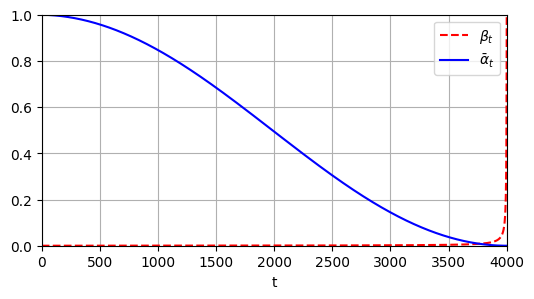

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(beta, "r--", label=r"$\beta_t$")
plt.plot(alpha_cumprod, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1])
plt.grid(True)
plt.xlabel(r"t")
plt.legend()
plt.show()

In [14]:
def prepare_batch(X):
    # For MNIST we add channel dimension
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1
    X_shape = tf.shape(X)
    # Times along forwards process to 
    # randomly select data for a batch
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1,dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    # Reshape for broadcasting
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        # Inputs for the inverse process
        'X_noisy': alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        'time': t,
    }, noise # The target for inverse process

In [16]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds.shuffle(buffer_size=10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

In [ ]:
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

In [20]:
train_set.take(1).get_single_element()

({'X_noisy': <tf.Tensor: shape=(32, 28, 28, 1), dtype=float32, numpy=
  array([[[[-0.6515835 ],
           [-0.8677928 ],
           [-0.5522784 ],
           ...,
           [-0.48567656],
           [-0.77727383],
           [-0.9103804 ]],
  
          [[-1.0653346 ],
           [-0.76847005],
           [-1.2499058 ],
           ...,
           [-0.2678064 ],
           [-1.3649364 ],
           [-0.59446895]],
  
          [[-1.2130944 ],
           [-1.1207048 ],
           [-1.1808338 ],
           ...,
           [-1.3677619 ],
           [-1.23108   ],
           [-0.7816258 ]],
  
          ...,
  
          [[-0.78952   ],
           [-0.43651992],
           [-1.3215861 ],
           ...,
           [-1.2148371 ],
           [-0.62421834],
           [-1.2830353 ]],
  
          [[-0.9108849 ],
           [-0.9642799 ],
           [-0.5939088 ],
           ...,
           [-0.94971114],
           [-0.9082103 ],
           [-1.459542  ]],
  
          [[-0.7970577 ],
      

In [21]:
def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

In [24]:
X_dict, Y_noise = list(train_set.take(1))[0]

In [25]:
X_original = subtract_noise(X_dict['X_noisy'], X_dict['time'], Y_noise)

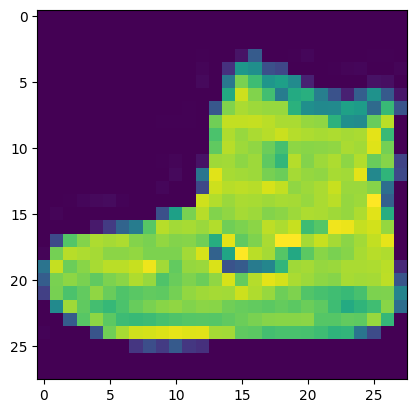

In [28]:
plt.imshow(X_original[0])

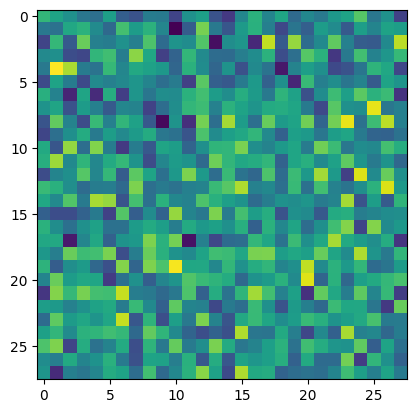

In [29]:
plt.imshow(X_dict['X_noisy'][0])

In [77]:
embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        # Returns embedding vectors taken at time positions 
        # indicated by inputs
        return tf.gather(self.time_encodings, inputs)

In [84]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name='X_noisy')
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name='time')
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation('relu')(Z)

    # Projecting down to the CNN channels dimension
    time = tf.keras.layers.Dense(dim)(time_enc)
    # Add H, W spatial dimensions and add time embedding
    # to every pixel
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z

    # Skip connection within in-out segemnt
    skip = Z
    # Skip connection across U-net in-out segments
    cross_skips = []

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation('relu')(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation('relu')(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)

        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(Z)
        # Pooling skip-link connection by 1x1 convoluiton with stride
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2, padding='same')(skip)
        # This can be added now to Z thus formink the skip connection
        Z = tf.keras.layers.add([Z, skip_link])

        # Readding time embedding after block processed data
        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z

        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation('relu')(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation('relu')(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding='same')(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding='same')(Z)[:, 2:-2, 2:-2]
    return tf.keras.models.Model(inputs=[X_noisy, time_input], outputs=[outputs])
        
        


In [85]:
model = build_diffusion_model()

In [86]:
model.compile(loss=tf.keras.losses.Huber(), optimizer='nadam')

In [87]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('diffusion_model', save_best_only=True)

In [ ]:
history = model.fit(train_set, validation_data=valid_set, epochs=100, callbacks=[checkpoint_cb])

In [90]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f'\rt = {t}', end=' ')
        noise = (tf.random.normal if t > 1 else np.zeros)(tf.shape(X))
        X_noise = model({'X_noisy': X, 'time': tf.constant([t] * batch_size)})
        X = (
        1 / alpha[t] ** 0.5
        * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
        + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

In [91]:
X_gen = generate(model)

t = 1    

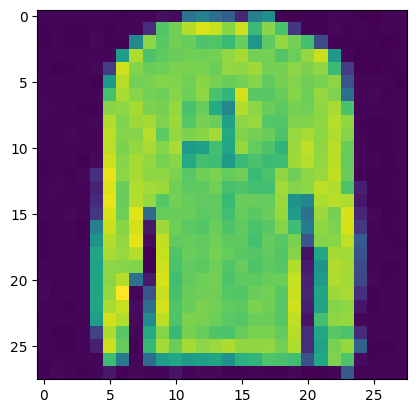

In [94]:
plt.imshow(X_gen[0])